In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find

from run_id import run_id
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)
print(q.id)

wos_all
365


In [55]:
t = Topic.objects.get(pk=108973)

ts = Topic.objects.filter(pk__in=[108973,108966])

dts = DocTopic.objects.filter(topic__in=ts)

dtdf = pd.DataFrame.from_dict(list(dts.order_by('topic__id','-score').values('doc__id','score','topic__title','doc__PY')))

dtdf.head()

,doc__PY,doc__id,score,topic__title
0,2011,186778,0.118646,"{health, pollut, air}"
1,2015,579739,0.116286,"{health, pollut, air}"
2,2010,466489,0.114664,"{health, pollut, air}"
3,2007,122532,0.113167,"{health, pollut, air}"
4,2013,531090,0.113034,"{health, pollut, air}"


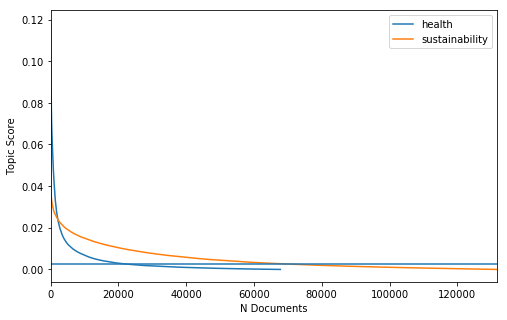

In [65]:
#dtdf['index'] = dtdf.index
plt.rcParams["figure.figsize"] = [8,5]
health = dtdf[dtdf['topic__title']=='{health, pollut, air}'].reset_index()
sus = dtdf[dtdf['topic__title']!='{health, pollut, air}'].reset_index()

p1 = health['score'].plot()
p2 = sus['score'].plot()
plt.axhline(y=stat.dthreshold)
plt.legend(p1.lines[0:2],["health","sustainability"])
plt.xlabel('N Documents')
plt.ylabel('Topic Score')
plt.savefig('../plots/health_sustain_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

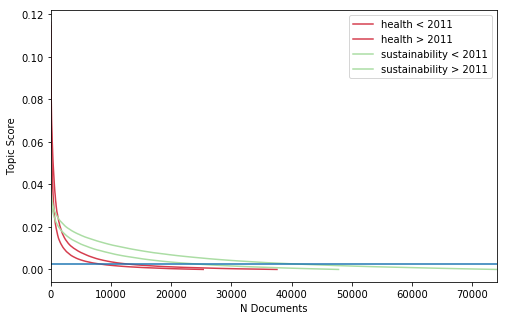

In [63]:
cutoff = 2011

#dtdf['index'] = dtdf.index
plt.rcParams["figure.figsize"] = [8,5]
health_early = dtdf[(dtdf['topic__title']=='{health, pollut, air}') & (dtdf['doc__PY']<cutoff)].reset_index()
health_late = dtdf[(dtdf['topic__title']=='{health, pollut, air}') & (dtdf['doc__PY']>cutoff)].reset_index()
sus_early = dtdf[(dtdf['topic__title']!='{health, pollut, air}') & (dtdf['doc__PY']<cutoff)].reset_index()
sus_late = dtdf[(dtdf['topic__title']!='{health, pollut, air}') & (dtdf['doc__PY']>cutoff)].reset_index()

colorset=["#d53e4f","#f46d43","#fdae61","#fee08b","#e6f598","#abdda4","#66c2a5","#3288bd"]

p1 = health_early['score'].plot(color="#d53e4f")
p2 = health_late['score'].plot(color="#d53e4f")
p3 = sus_early['score'].plot(color=colorset[5])
p4 = sus_late['score'].plot(color=colorset[5])
plt.axhline(y=stat.dthreshold)
plt.legend(p1.lines[0:4],[
    "health < {}".format(cutoff),
    "health > {}".format(cutoff),
    "sustainability < {}".format(cutoff),
    "sustainability > {}".format(cutoff)
])
plt.xlabel('N Documents')
plt.ylabel('Topic Score')
#plt.savefig('../plots/health_sustain_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [53]:
t = Topic.objects.get(pk=108973)


dts = DocTopic.objects.filter(topic=t)

dtdf = pd.DataFrame.from_dict(list(dts.order_by('-score').values('doc__id','score','topic__title','doc__PY')))

dtdf.head()

,doc__PY,doc__id,score,topic__title
0,2010,500186,0.056684,"{research, manag, sustain}"
1,2016,709697,0.053547,"{research, manag, sustain}"
2,2013,42450,0.052410,"{research, manag, sustain}"
3,2011,69886,0.052231,"{research, manag, sustain}"
4,2014,682523,0.048519,"{research, manag, sustain}"


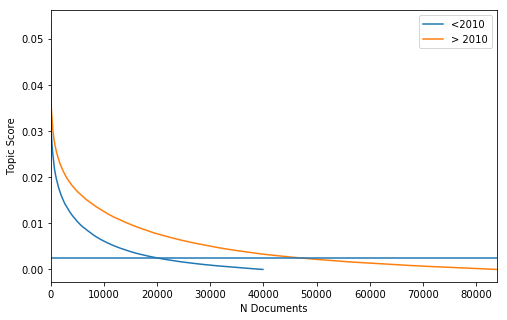

In [54]:
#dtdf['index'] = dtdf.index
plt.rcParams["figure.figsize"] = [8,5]
early = dtdf[dtdf['doc__PY']<2010].reset_index()
late = dtdf[dtdf['doc__PY']>2010].reset_index()

p1 = early['score'].plot()
p2 = late['score'].plot()
plt.axhline(y=stat.dthreshold)
plt.legend(p1.lines[0:2],["<2010","> 2010"])
plt.xlabel('N Documents')
plt.ylabel('Topic Score')
plt.savefig('../plots/health_sustain_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [94]:
from tmv_app.views import *

## Cotopics:
topic_ids = [108931,108922,108927]

for t in topic_ids:
    sus = Topic.objects.get(pk=108973)
    tts = Topic.objects.filter(pk__in=[t,108973])
    doctopics = DocTopic.objects.filter(
        topic__in=tts,
        score__gt=0
    )
    
    combine = doctopics.values('doc').annotate(
        topic_combination = Sum('score'),
        count = Count('score')
    ).filter(count__gte=len(tts))
    

    annotation = {}

    combine2 = combine.values('doc')
    for tt in tts:
        #top = Topic.objects.get(pk=t)
        annotation[tt.title] = Sum(
            Case(When(topic=tt,then=F('score')),
                #default=0,
                output_field=models.FloatField()
            )
        )
        
    print(annotation)

    combine2 = combine2.annotate(**annotation)
    combine2 = combine2.annotate(topic_combination=F(tts[0].title))

    for i in range(1,len(tts)):
        combine2 = combine2.annotate(
            topic_combination=F('topic_combination')*F(tts[i].title)
        )
        
    print(Topic.objects.get(pk=t))
    y = combine2.order_by('-topic_combination')[:5]
    for x in y:
        d = Doc.objects.get(pk=x['doc'])
        print(d.title)

{'{polici, govern, tax}': Sum(CASE WHEN <Q: (AND: ('topic', <Topic: {polici, govern, tax}>))> THEN F(score), ELSE Value(None)), '{research, manag, sustain}': Sum(CASE WHEN <Q: (AND: ('topic', <Topic: {research, manag, sustain}>))> THEN F(score), ELSE Value(None))}
{polici, govern, tax}
How Research-Prioritization Exercises Affect Conservation Policy
Role of hydrology and economics in water management policy under increasing uncertainty
Informing food policy: balancing the evidence
The identification of priority policy options for UK nature conservation
Environmental education policy research challenges and ways research might cope with them
{'{adapt, vulner, strategi}': Sum(CASE WHEN <Q: (AND: ('topic', <Topic: {adapt, vulner, strategi}>))> THEN F(score), ELSE Value(None)), '{research, manag, sustain}': Sum(CASE WHEN <Q: (AND: ('topic', <Topic: {research, manag, sustain}>))> THEN F(score), ELSE Value(None))}
{adapt, vulner, strategi}
Methodological choices in solution-oriented adaptati

In [93]:
y[0]['doc']

717806